In [61]:


import pandas as pd
!pip install matplotlib pandas numpy-financial



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
class Mortgage:
    def __init__(
            self,
            principal,
            annual_interest_rate,
            annual_tr,
            max_months,
            monthly_payment,
            min_monthly_valorization=0.001,
            max_monthly_valorization=0.011,
            adhoc=None
    ):
        if adhoc is None:
            adhoc = dict()
        self.principal = principal
        self.annual_interest_rate = annual_interest_rate
        self.annual_tr = annual_tr
        self.monthly_payment = monthly_payment
        self.max_months = max_months
        self.min_monthly_valorization = min_monthly_valorization
        self.max_monthly_valorization = max_monthly_valorization
        self.adhoc = adhoc

    def calculate(
            self,
    ):
        df = pd.DataFrame(
            columns=[
                "remaining_balance",
                "added_interest",
                "total_interest",
                "payment",
                "total_paid",
                "amortized_amount",
                "min_value",
                "max_value",
                "min_valorization",
                "max_valorization"
            ]
        )
        monthly_interest_rate = (self.annual_interest_rate + self.annual_tr) / 12 / 100

        total_paid = 0
        total_interest = 0
        current_balance = self.principal
        month = 0
        min_value = current_balance
        max_value = current_balance

        while current_balance > 0:
            interest = current_balance * monthly_interest_rate
            payment_for_month = self.get_payment_for_month(current_balance + interest, month)

            new_balance = current_balance - payment_for_month + interest
            min_value *= (1 + self.min_monthly_valorization)
            max_value *= (1 + self.max_monthly_valorization)
            
            amortized_amount = payment_for_month - interest
            
            df.loc[month] = [
                current_balance,
                interest,
                total_interest,
                payment_for_month,
                total_paid,
                amortized_amount,
                min_value,
                max_value,
                min_value - self.principal,
                max_value - self.principal
            ]

            total_paid += payment_for_month
            total_interest += interest

            current_balance = new_balance

            month += 1
            if month > self.max_months:
                break

        return df

    def get_payment_for_month(self, current_balance, month):
        total_payment = self.monthly_payment
        adhoc_pay = self.adhoc.get(month, None)
        if adhoc_pay is not None:
            total_payment += adhoc_pay
        if total_payment > current_balance:
            total_payment = current_balance
        return total_payment

In [63]:
configurations = [
    Mortgage(
        150000,
        9.99,
        0,
        360,
        5000
    ),
    Mortgage(
        240000,
        9.99,
        0,
        360,
        2578.63
    ),
    Mortgage(
        585000,
        9.99,
        0,
        360,
        15000
    ),
    Mortgage(
        321252.03,
        8.27,
        1.76,
        342,
        3270.64,
        adhoc={
            20: 50000,
            35: 35000,
            45: 10000,
            80: 50000
        }),
    Mortgage(
        321252.03,
        8.27,
        1.76,
        342,
        5000,
        adhoc={
            20: 50000,
            35: 35000,
            45: 10000,
            80: 50000
        }),
    Mortgage(
        321252.03,
        8.27,
        1.76,
        342,
        8000,
        adhoc={
            20: 50000,
            35: 35000,
            45: 10000,
            80: 50000
        })
]
for principals in [300000, 450000, 665000, 800000]:
    for interest_rate_over_year in [6.5, 8.4, 10.8]:
        for monthly_payment in [3000, 5000, 8000, 15000, 20000]:
            for years in [10, 30]:
                for fgts in [0, 14400]:
                    configurations.append(
                        Mortgage(principals, interest_rate_over_year, 1.76, years * 12, monthly_payment, fgts),
                    )


In [64]:
NEW_INN = 880000
POLO = 100000
CASA = 180000
ENTRADA = POLO + CASA
for monthly_payment in [3000, 5000, 8000, 15000, 20000]:
    m = Mortgage(NEW_INN - ENTRADA, 8.27, 1.76, 342, monthly_payment)
    configurations.append(m)
    m.calculate()

OverflowError: int too large to convert to float

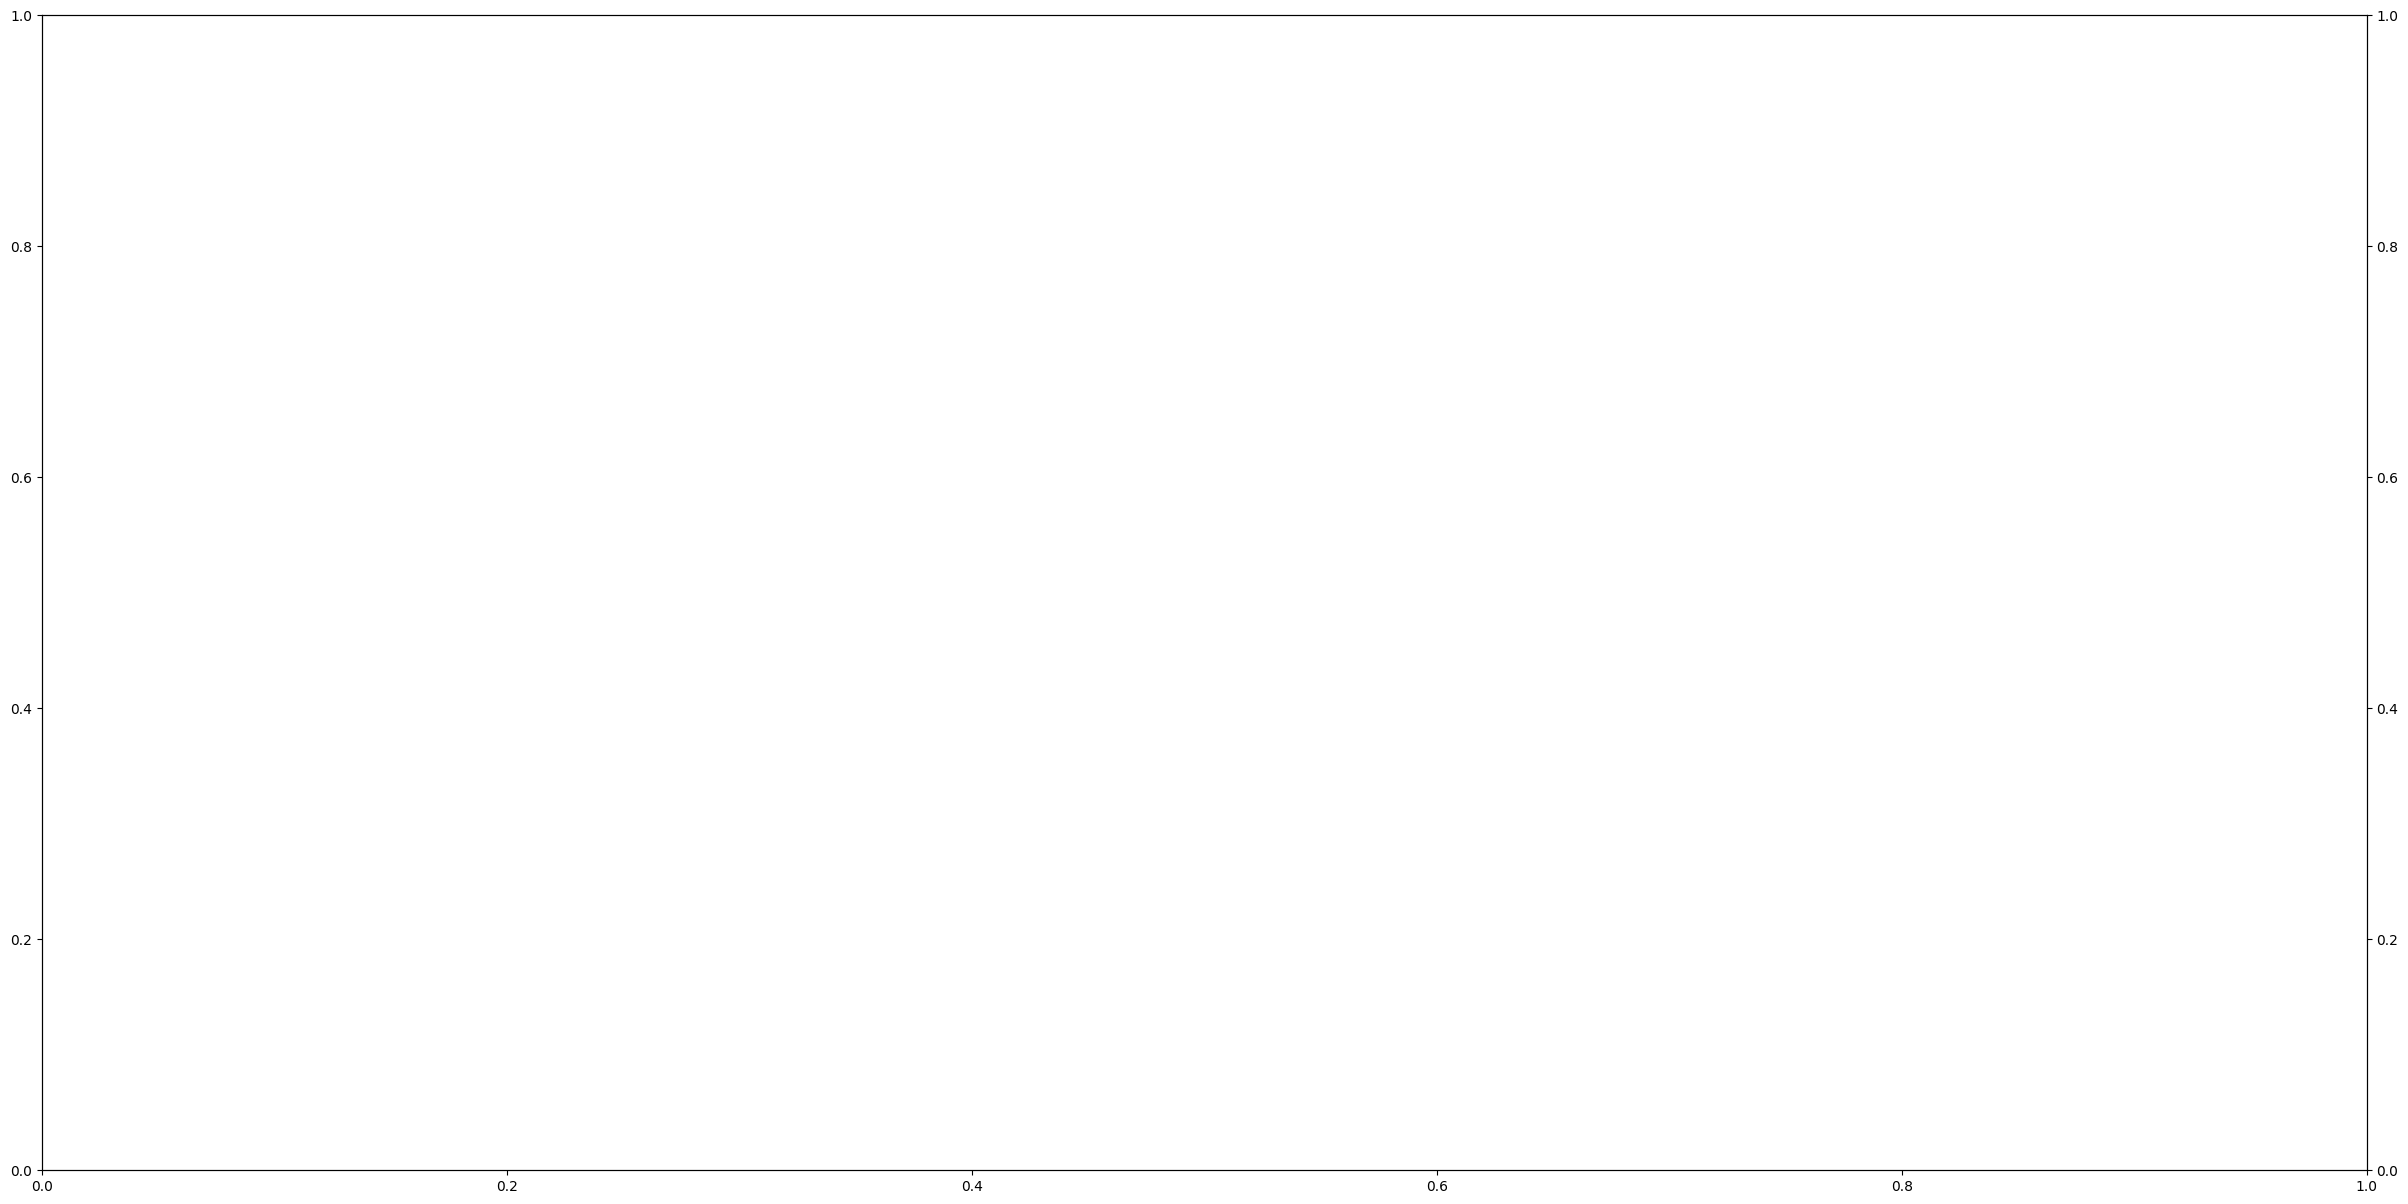

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pathlib

for mortgage in configurations:
    fig = plt.figure(figsize=(30, 15))
    ax1 = plt.gca()  # Get current axis for primary y-axis
    ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis

    df = mortgage.calculate()

    total_num_payments = len(df)
    total_paid = df['payment'].sum()
    total_interest = df['added_interest'].sum()

    ax2.plot(
        df.index,
        df['total_interest'] + mortgage.principal,
        color='orange',
        label="Loan paid with interest over time"
    )
    ax1.stackplot(
        df.index,
        [df['payment'] - df['added_interest'], df['added_interest']],
        labels=['Amortization', 'Interest'],
        colors=['green', 'red'],
        alpha=0.5,
        step="post"
    )

    ax2.fill_between(
        df.index,
        df['min_value'],
        df['max_value'],
        alpha=0.25,
        label="Possible valorization"
    )
    avg_val = (df['min_value'] + df['max_value']) / 2
    ax2.plot(
        df.index,
        avg_val,
        'k-',  # 'k-' stands for black solid line
        label="Average possible valorization"
    )

    ax2.plot(df.index, df['remaining_balance'], label="Balance", color='red')
    ax1.set_title(
        f"{mortgage.principal} BRL, {mortgage.max_months} months, monthly payment of {mortgage.monthly_payment}, "
        f"Annual interest: {mortgage.annual_interest_rate}: BRL {total_paid:,} ({total_paid / mortgage.principal:,}x), "
        f"Total Interest: {total_interest}"
    )
    ax1.set_xlabel('Months')
    ax1.set_ylabel('Amount in BRL (Payments, Interest, Amortization)')
    ax2.set_ylabel('Amount in BRL (Remaining Balance)')

    # Legend and grid setup
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')
    ax1.grid(True)

    # Format y-axis to be more readable
    formatter = FuncFormatter(lambda y, _: f'{int(y):,}')
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)

    path = pathlib.Path(f"charts/{mortgage.principal}/{mortgage.monthly_payment}BRL month/{mortgage.annual_interest_rate}%.png")
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path)
    plt.close()
